inspired by https://projects.volkamerlab.org/teachopencadd/talktorials/T004_compound_similarity.html#Tanimoto-coefficient

In [1]:
# General python libraries and packages
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os

# Processing chemical data
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem, Descriptors, Draw, MACCSkeys, rdFingerprintGenerator
from rdkit.Chem.Draw import MolsToGridImage, rdMolDraw2D, MolsMatrixToGridImage, IPythonConsole
from rdkit.Chem import rdFMCS

# Data Visualization
import matplotlib.pyplot as plt

In [2]:
# Adjust how molecules are drawn! 
dpi = 300
canvas_size = 600  
d2d = Draw.MolDraw2DCairo(canvas_size, canvas_size) # Use a fixed canvas size
dopts = d2d.drawOptions()
dopts.fixedFontSize = 14
dopts.legendFontSize = 16
dopts.dummiesAreAttachments = True # Replace * by wavy lines
# dopts.addStereoAnnotation = True

# Print all the drawing options
# for attr in dir(dopts):
#      if not attr.startswith('_') and not callable(getattr(dopts, attr)):
#         try:
#             print(f"{attr}: {getattr(dopts, attr)}")
#         except Exception as e:
#             print(f"{attr}: <error reading value: {e}>")

# Set the drawOptions variable in the PandasTools module accordingly
PandasTools.drawOptions = dopts

# Also set how molecules are rendered within the Jupyter Notebook
IPythonConsole.drawOptions = dopts

# Import Dataset 
(File was generated in the 2_Data_Preparation_and_Overlap JupyterNotebook)

40290


,Dataset,ID,Ligand_Instance,PDB_ID,Standardized_SMILES,SMILES,Name,Pocket,ATP_Site,Peripheral,Num_H_Atoms_ProtBoundConf,Num_Resolved_Atoms,Num_Not_Resolved_Atoms,Mol_2D
0,CF,F001,001_B_2,NaN,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,O[C@H](C1)CN[C@@H]1c1nc(-c(cc2)ccc2F)n[o]1,"(3R,5S)‐5‐[3‐(4‐fluorophenyl)‐1,2,4‐oxadiazol‐...",X,1.0,1.0,13.0,18.0,0.0,

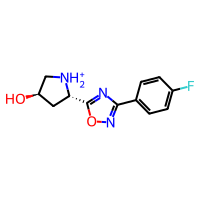

In [3]:
df = pd.read_excel(os.path.join('Data', '_Molecule_Data_Combined.xlsx'))

# Draw molecules
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="Standardized_SMILES", molCol='Mol_2D')
PandasTools.RenderImagesInAllDataFrames(True)

print(len(df))
df.head(1)

# Compute Morgan Fingerprints (Radius = 2, 4096 Bits)
**Substructure-based fingerprints** <br>
Molecular fingerprints are a computational representation of molecules that encode chemical and molecular features in the form of bitstrings, bitvectors or arrays. Each bit corresponds to a predefined molecular feature or environment, where “1” represents the presence and “0” the absence of a feature. Note that some implementations are count-based. Thus, they count how often a specific feature is present. <br> 

**Morgan Fingerprints** <br>
This family of fingerprints is based on the Morgan algorithm. The bits correspond to the circular environments of each atom in a molecule. The number of neighboring bonds and atoms to consider is set by the radius. Also the length of the bit string can be defined, a longer bit string will be modded to the desired length. Therefore, the Morgan fingerprint is not limited to a certain number of bits. More about the Morgan fingerprint can be found in the rdkit documentation. 

,Dataset,ID,Ligand_Instance,PDB_ID,Standardized_SMILES,SMILES,Name,Pocket,ATP_Site,Peripheral,Num_H_Atoms_ProtBoundConf,Num_Resolved_Atoms,Num_Not_Resolved_Atoms,Mol_2D,MorganFP
0,CF,F001,001_B_2,NaN,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,O[C@H](C1)CN[C@@H]1c1nc(-c(cc2)ccc2F)n[o]1,"(3R,5S)‐5‐[3‐(4‐fluorophenyl)‐1,2,4‐oxadiazol‐...",X,1.0,1.0,13.0,18.0,0.0,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

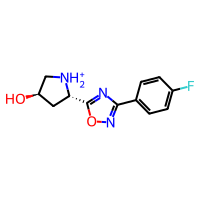

In [4]:
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096) #countSimulation=False, includeChirality=True
df["MorganFP"] = df["Mol_2D"].map(fpg.GetFingerprint)
df.head(1)

# Compute Pairwise Tanimoto Similarity 

**Molecular similarity** can be quantified with a number of different similarity coefficients, one common similarity measures is the Tanimoto  coefficient.  <br> 
The similarity measures usually consider the number of 1s present in either fingerprint and the number of 1s that both have in common. <br> [G. Maggiora, M. Vogt, D. Stumpfe, J. Bajorath. Molecular Similarity in Medicinal Chemistry. J. Med. Chem. (2014), 57, 3186-3204] <br> 

**Tanimoto coefficient = c / (a + b - c)** <br> 
a: number of features present in molecule A <br> 
b: number of features present in molecule B <br> 
c: number of features shared by molecules A and B <br> 




In [5]:
CF_df = df[df['Dataset'] == 'CF']
print(len(CF_df))

# Keep only the rows from the reference datasets 
df = df[df['Dataset'] != 'CF']
df = df.reset_index(drop=True)
print(len(df))

57
40233


In [6]:
# Initialize dictionary
top_3_similar = {}

# Iterate over each fragment, and compute the pairwise tanimoto similarity.
for index, row in CF_df.iterrows():  

    # Calculate similarity coefficients
    df[f"Tanimoto_{row['ID']}"] = DataStructs.BulkTanimotoSimilarity(row['MorganFP'], df['MorganFP'])

    # Get the top 3 similar compounds based on the Tanimoto similarity
    top_3 = df.nlargest(3, f"Tanimoto_{row['ID']}")

    # Add the most similar compounds to the dictionary, using the FRG ID as the key
    top_3_similar[row['ID']] = top_3

In [7]:
# # Write dataframe to file
filepath = os.path.join('Analysis', 'Chemotypes')
df.to_excel(os.path.join(filepath, 'Molecular_Similarity_of_FRGs_and_Reference_Molecules.xlsx'), index=False)

# Look at Highest Tanimoto Coefficient (per Fragment)

In [8]:
def compute_mean_tanimoto(similar_mols_dict): 
    # Initialize dictionary of highest Tanimoto coefficients per fragment
    highest_tanimoto_dict = {}
    # Iterate through the dict
    for frg_id, df in similar_mols_dict.items():
        # Look up the highest Tanimoto coefficient and append value to dictionary
        value = round(df[f'Tanimoto_{frg_id}'].max(), 2)
        highest_tanimoto_dict[frg_id]=value
    print("Mean tanimoto cofficient =", round(np.mean(list(highest_tanimoto_dict.values())), 2))
    print("Median tanimoto cofficient =", round(np.median(list(highest_tanimoto_dict.values())), 2))
    return highest_tanimoto_dict 

highest_tanimoto_dict = compute_mean_tanimoto(top_3_similar)

# print(highest_tanimoto_dict)
# plt.hist(list(highest_tanimoto_dict.values()), bins=6, edgecolor='black')
# plt.xlim(0.1, 0.5)

Mean tanimoto cofficient = 0.31
Median tanimoto cofficient = 0.32


# Draw the top 3 most similar reference molecules per fragment

In [9]:
def draw(similar_mols_dict, frg_list, filename): 

    # Create a subdictionary for the fragments specified in the frg_list
    sub_similar_mols_dict = {k: v for k, v in similar_mols_dict.items() if k in frg_list}

    # Prepare the list of molecules and legends for drawing
    molecules = []
    legends = []

    # Define the drawing options, in specific the font size and the legend area
    # dopts = Draw.MolDrawOptions()
    dopts.legendFraction = 0.15 # default = 0.1 = 10% of the image
    # dopts.legendFontSize = 12

    # Iterate through the sub dict
    for frg_id, df in sub_similar_mols_dict.items():

        # Look up the fragment structure in CF_df
        fragment = CF_df.loc[CF_df['ID'] == frg_id, 'Mol_2D'].values[0]
        # Add the fragment to the molecules list
        molecules.append(fragment)
        # Append the Fragment ID to the legends list
        legends.append(frg_id)

        # Add the similar compounds
        for index, row in df.iterrows():
            # Retrieve the reference molecule
            similar_mol = row['Mol_2D']
            # Orientate the similar_mol the same way as the fragment, if possible (requires a matching substructure)
            try: 
                mcs = rdFMCS.FindMCS([fragment, similar_mol])
                patt = Chem.MolFromSmarts(mcs.smartsString)
                query_match = similar_mol.GetSubstructMatch(patt)
                template_match = fragment.GetSubstructMatch(patt)
                AllChem.Compute2DCoords(fragment)
                AllChem.Compute2DCoords(similar_mol)
                rms = AllChem.AlignMol(similar_mol, fragment, atomMap=list(zip(query_match,template_match)))
                AllChem.GenerateDepictionMatching2DStructure(similar_mol, fragment)
            except:
                pass
            molecules.append(similar_mol)

            # Extract the Reference Molecule's ID or Name
            if row['Dataset'] in ['PKIs', 'OralDrugs']:
                ref_mol_id = row['Name']
            else: 
                ref_mol_id = row['ID']
            
            # Add the Reference Molecule's ID, the source dataset and the tanimoto coefficient to the legends list
            legends.append(f"{ref_mol_id} \n ({row['Dataset'].replace('_', ' ')}) \n {row[f'Tanimoto_{frg_id}']:.2f}")

    # Draw the molecules in a grid
    img = MolsToGridImage(mols=molecules, legends=legends, molsPerRow=4, subImgSize=(300,300), drawOptions=dopts, returnPNG=False)

    # Save image to file
    if filename:
        img.save(os.path.join(filepath, f"{filename}_Most_Similar_Reference_Molecules.png"))

    return img

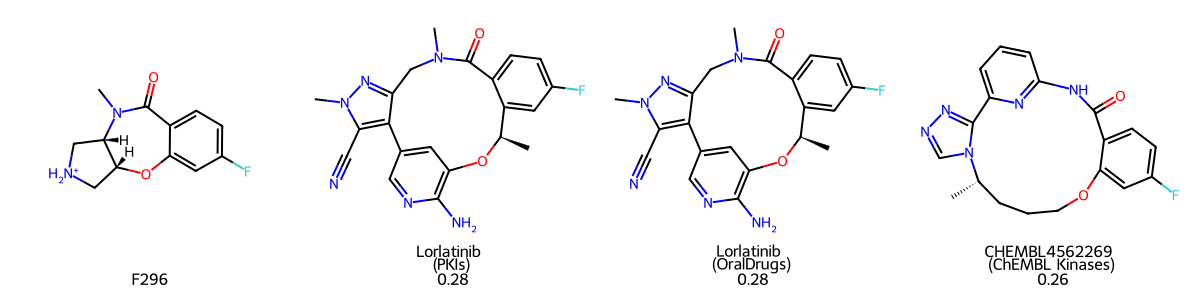

In [10]:
# Call the draw function to visualize the similar molecules for the given Fragment ID
draw(similar_mols_dict = top_3_similar, 
     frg_list = ['F296'],
     filename = 'F296'
     )

In [11]:
# Write the Fragment IDs to a list 
complete_frg_list = sorted(list(set(CF_df['ID'].to_list())))

In [12]:
# Call the draw function to visualize the similar molecules for each individual Fragment 
for frg in complete_frg_list: 
    
    draw(similar_mols_dict = top_3_similar, 
     frg_list = [frg],
     filename = frg)

In [13]:
# Instead of creating an image for every fragment, use 'chunks' of fragments
# Here: 6 Fragments (along with their most similar reference molecules) per Image

def chunk_list(input_list, chunk_size):
    """
    This function takes an input list and a specified chunk size,
    and yields slices of the list in chunks of the given size.
    """
    for i in range(0, len(input_list), chunk_size):
        yield input_list[i:i + chunk_size]

# Create a list of chunks from complete_frg_list, with each chunk containing 6 elements
frg_list_chunks = list(chunk_list(complete_frg_list, 6))

# Iterate over each sublist in frg_lists
for frg_list in frg_list_chunks: 
    # Print the current chunk of fragment IDs
    print(frg_list)
    # Call the draw function to visualize the similar molecules for the current chunk of fragment IDs
    draw(similar_mols_dict = top_3_similar, 
    frg_list = frg_list,
    filename = f'{frg_list[0]}_to_{frg_list[-1]}')

['F001', 'F005', 'F009', 'F012', 'F024', 'F030']
['F032', 'F055', 'F058', 'F070', 'F073', 'F074']
['F102', 'F134', 'F138', 'F145', 'F168', 'F184']
['F186', 'F188', 'F189', 'F203', 'F225', 'F236']
['F248', 'F264', 'F274', 'F283', 'F294', 'F296']
['F299', 'F304', 'F310', 'F312', 'F313', 'F322']
